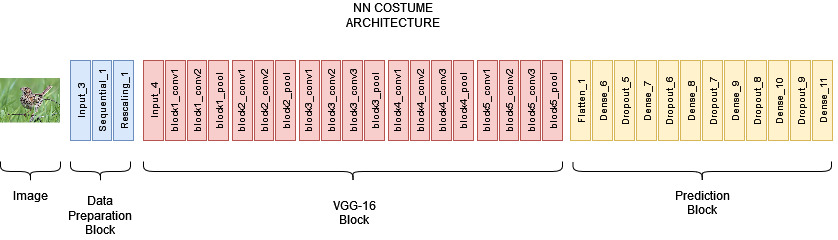


# DNN Spliting Code
Some considerations:
1. The *original_model* is the  desire DNN to split. In this case our original model is saved in Google Drive and in h5 format.
2. The First block (Data Preparation) and the last one (Sequential Layers) are already defined.
3. The amouunt of splitting blocks of the models is decided by *num_submodels*, but, as mentioned before, the first layer (Data Preparation) and the last ones (Predition Block) are already defined. On the other hand, the amount of split in the VGG-16 can be from 1 to 5, using the variable *num_intermediate_submodels*, with 1 th VGG-16 is a full block, instead with 5 the VGG-16 is split into 5 blocks (Coherent Splitting) for a total of 3 and 7 blocks respectivly.
4. The create_intermediate_submodel funtion takes the whole VGG-16 block and split it based on the start layer and the end layer.
5. The split model verify that the parameres are been respected and then proceed with the splitting of the models  
5. The layer names list are the layers of the VGG-16 models.
6. The submodes (splitting blocks) are saved in h5 format.

In [2]:
from keras.models import Model
import tensorflow as tf

def create_intermediate_submodel(vgg16_block, start_layer, end_layer):
    submodel_input = vgg16_block.get_layer(name=start_layer).input
    submodel_output = vgg16_block.get_layer(name=end_layer).output
    return Model(inputs=submodel_input, outputs=submodel_output)

def save_submodel_to_h5(submodel, submodel_name):
    submodel.save(submodel_name + '.h5')

def split_model(original_model, num_submodels):
    if num_submodels < 3 or num_submodels > 7:
        print("Error: The number of submodels must be between 3 and 7.")
        return None

   #First Block creation (Data Preparation)
    previous_layer_name = 'input_3'
    predicted_layer_name = 'rescaling_2'
    previous_layer_input = original_model.get_layer(name=previous_layer_name).input
    predicted_layer_output = original_model.get_layer(name=predicted_layer_name).output
    first_submodel = Model(inputs=previous_layer_input, outputs=predicted_layer_output)

   #Last Block creation (Prediction)
    previous_layer_name_final = 'flatten_1'
    predicted_layer_name_final = 'dense_11'
    previous_layer_input_final = original_model.get_layer(name=previous_layer_name_final).input
    predicted_layer_output_final = original_model.get_layer(name=predicted_layer_name_final).output
    last_submodel = Model(inputs=previous_layer_input_final, outputs=predicted_layer_output_final)

    #VGG-16 splitting creation
    layer_names = ['input_4', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1',
                   'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3',
                   'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool',
                   'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']

    num_intermediate_submodels = num_submodels - 2
    intermediate_submodels = []
    vgg16_block = original_model.get_layer('vgg16')

    if num_intermediate_submodels == 1:
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'input_4', 'block5_pool'))
    if num_intermediate_submodels == 2:
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'input_4', 'block3_pool'))
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'block4_conv1', 'block5_pool'))
    if num_intermediate_submodels == 3:
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'input_4', 'block2_pool'))
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'block3_conv1', 'block3_pool'))
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'block4_conv1', 'block5_pool'))
    if num_intermediate_submodels == 4:
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'input_4', 'block2_pool'))
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'block3_conv1', 'block3_pool'))
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'block4_conv1', 'block4_pool'))
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'block5_conv1', 'block5_pool'))
    if num_intermediate_submodels == 5:
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'input_4', 'block1_pool'))
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'block2_conv1', 'block2_pool'))
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'block3_conv1', 'block3_pool'))
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'block4_conv1', 'block4_pool'))
        intermediate_submodels.append(create_intermediate_submodel(vgg16_block, 'block5_conv1', 'block5_pool'))

    return [first_submodel] + intermediate_submodels + [last_submodel]

# Test
original_model = tf.keras.models.load_model('/content/drive/MyDrive/vgg15_dataset21_lv.h5')
num_submodels = 3
submodels = split_model(original_model, num_submodels)

if submodels is not None:
    print("List of Submodels:")
    for i, submodel in enumerate(submodels):
        submodel_name = f"submodel_test{i + 1}"
        print(f"Submodel_test {i + 1} Name: {submodel_name}")
        #save_submodel_to_h5(submodel, submodel_name)

        print(f"\nSubmodel_test {i + 1} Summary:")
        submodel.summary()

List of Submodels:
Submodel_test 1 Name: submodel_test1

Submodel_test 1 Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Submodel_test 2 Name: submodel_test2

Submodel_test 2 Summary:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 

# Test Code
The code uses a pre-trained TensorFlow/Keras model to classify an input image. It preprocesses the image to match the model's requirements, predicts its class, and outputs the most likely class along with the confidence score.

In [3]:
import numpy as np

#model = tf.keras.models.load_model('vgg15_dataset21_lv.h5')
model = original_model

#Load and preprocess the input image from your local drive
image_path = ''  #Replace with the actual path of the image
img = tf.keras.preprocessing.image.load_img(
    image_path, target_size=(224, 224)  # Adjust the target size to match your model
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)  # Create a batch

#Predictions
predictions = model.predict(img_array)

#Class names
class_names = ['Albatross', 'Auklet', 'Blackbird', 'Bunting', 'Cormorant', 'Cuckoo', 'Flycatcher', 'Grosbeak', 'Gull', 'Grebe', 'Hummingbird', 'Jay', 'Kingfisher', 'Oriole', 'Sparrow', 'Swallow', 'Tern', 'Vireo', 'Warbler', 'Wren', 'Woodpecker']


#Print the predicted class and confidence
predicted_class = class_names[np.argmax(predictions)]
confidence = 100 * np.max(predictions)

print(
    f"This image most likely belongs to {predicted_class} with a {confidence:.2f} percent confidence."
)

1/1 [==============================] - 1s 1s/step
This image most likely belongs to Albatross with a 99.17 percent confidence.
